# Facebook data analysis

In this Python notebook, the various methods for extracting data from the Facebook Ads Archive and subsequently doing analyses on the extracted data will be discussed.

## 1. Install and import packages

In [2]:
import yaml
import requests
import csv
import re
from tqdm import tqdm
from itertools import product    

import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yossigijrath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Yossigijrath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. Setting parameters and import yaml

In order to retrieve the correct information from Facebook, several parameters need to be set. Some parameters need to be changed in the config.yaml file

In [3]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

assert config['search_total'] % config['page_total'] == 0, \
    "search_total should be a multiple of page_total."

params = {
    'access_token': config['access_token'],
    'ad_type': 'POLITICAL_AND_ISSUE_ADS',
    'ad_delivery_date_max': '2021-03-17',
    'ad_delivery_date_min': '2020-09-01',
    'ad_reached_countries': "['NL']",
    'ad_active_status': config['ad_active_status'],
    'search_terms': " ",
    'search_page_ids': ['717249231795539'],
    'fields': ",".join(config['query_fields']),
    'limit': config['page_total']
}

## 3. Create CSV files 

In [3]:
REGIONS = set(config['regions'])
DEMOS = set(product(config['demo_ages'], config['demo_genders']))

f1 = open('fb_ads_bij1.csv', 'w')
w1 = csv.DictWriter(f1, fieldnames=config['output_fields'],
                    extrasaction='ignore')
w1.writeheader()

f2 = open('fb_ads_demos_bij1.csv', 'w')
w2 = csv.DictWriter(f2, fieldnames=config['demo_fields'],
                    extrasaction='ignore')
w2.writeheader()

f3 = open('fb_ads_regions_bij1.csv', 'w')
w3 = csv.DictWriter(f3, fieldnames=config['region_fields'],
                    extrasaction='ignore')
w3.writeheader()

pbar = tqdm(total=config['search_total'], smoothing=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

## 3. Scrape Facebook

In [4]:
for _ in range(int(config['search_total'] / config['page_total'])):
    r = requests.get('https://graph.facebook.com/v5.0/ads_archive',
                     params=params)
    data = r.json()
    for ad in data['data']:
        # The ad_id is encoded in the ad snapshot URL
        # and cannot be accessed as a normal field. (?!?!)

        ad_id = re.search(r'\d+', ad['ad_snapshot_url']).group(0)
        ad_url = 'https://www.facebook.com/ads/library/?id=' + ad_id

        # write to the unnested files
        demo_set = set()
        #if demo in ad.get('demographic_distribution') is not None:
        for demo in ad['demographic_distribution']:        
            demo.update({'ad_id': ad_id})
            w2.writerow(demo)
            demo_set.add((demo['age'], demo['gender']))
                
        #else:
         #   print("Error occored")
                
                
        region_set = set()
        for region in ad['region_distribution']:
            region.update({'ad_id': ad_id})
            w3.writerow(region)
            region_set.add(region['region'])
        

        '''# Impute a percentage of 0
        # for demos with insufficient data
        unused_demos = DEMOS - demo_set
        for demo in unused_demos:
            w2.writerow({
                'ad_id': ad_id,
                'age': demo[0],
                'gender': demo[1],
                'percentage': 0
            })


        # Impute a percentage of 0
        # for states with insufficient data
        unused_regions = REGIONS - region_set
        for region in unused_regions:
            w3.writerow({
                'ad_id': ad_id,
                'region': region,
                'percentage': 0
            })'''  


        ad.update({'ad_id': ad_id,
                   'ad_url': ad_url,
                   'impressions_min': ad['impressions']['lower_bound'],
                   'impressions_max': ad['impressions'].get('upper_bound'),
                   'spend_min': ad['spend']['lower_bound'],
                   'spend_max': ad['spend']['upper_bound'],
                   })

        w1.writerow(ad)
        pbar.update()

    # if we have scraped all the ads, exit
    if 'paging' not in data:
        break

    params.update({'after': data['paging']['cursors']['after']})

f1.close()
f2.close()
f3.close()
pbar.close()

KeyError: 'data'

## 4. Merge all CSV files 

In [8]:
import pandas as pd
import csv
'''
party_ads_csv = ['fb_ads_vvd.csv','fb_ads_cda.csv','fb_ads_d66.csv','fb_ads_gl.csv','fb_ads_pvda.csv','fb_ads_cu.csv','fb_ads_50plus.csv',
                'fb_ads_sgp.csv','fb_ads_sp.csv','fb_ads_pvdd.csv','fb_ads_denk.csv','fb_ads_fvd.csv','fb_ads_ja21.csv','fb_ads_volt.csv','fb_ads_bbb.csv','fb_ads_bij1.csv',
                ]

party_demo_csv = ['fb_ads_demos_vvd.csv','fb_ads_demos_cda.csv','fb_ads_demos_d66.csv','fb_ads_demos_gl.csv','fb_ads_demos_pvda.csv','fb_ads_demos_cu.csv','fb_ads_demos_50plus.csv',
                'fb_ads_demos_sgp.csv','fb_ads_demos_sp.csv','fb_ads_demos_pvdd.csv','fb_ads_demos_denk.csv','fb_ads_demos_fvd.csv','fb_ads_demos_ja21.csv','fb_ads_demos_volt.csv','fb_ads_demos_bbb.csv','fb_ads_demos_bij1.csv',
                ]

party_regions_csv = ['fb_ads_regions_vvd.csv','fb_ads_regions_cda.csv','fb_ads_regions_d66.csv','fb_ads_regions_gl.csv','fb_ads_regions_pvda.csv','fb_ads_regions_cu.csv','fb_ads_regions_50plus.csv',
                'fb_ads_regions_sgp.csv','fb_ads_regions_sp.csv','fb_ads_regions_pvdd.csv','fb_ads_regions_denk.csv','fb_ads_regions_fvd.csv','fb_ads_regions_ja21.csv','fb_ads_regions_volt.csv','fb_ads_regions_bbb.csv','fb_ads_regions_bij1.csv',
                ]

#combine all files from ads '''

combined_ads_csv = pd.concat([pd.read_csv(f) for f in party_ads_csv])
combined_ads_csv.head()

combined_ads_csv.to_csv( "combined_ads.csv", quotechar='"',
          quoting=csv.QUOTE_ALL, index=False, encoding='utf-8')

#combine all files from demos 

combined_demo_csv = pd.concat([pd.read_csv(f) for f in party_demo_csv])
combined_demo_csv.head()

combined_demo_csv.to_csv( "combined_demo.csv", quotechar='"',
          quoting=csv.QUOTE_ALL, index=False, encoding='utf-8')

#combine all files from regions 

combined_regions_csv = pd.concat([pd.read_csv(f) for f in party_regions_csv])
combined_regions_csv.head()

combined_regions_csv.to_csv( "combined_regions.csv", quotechar='"',
          quoting=csv.QUOTE_ALL, index=False, encoding='utf-8')


FileNotFoundError: File b'fb_ads_pvda.csv' does not exist

# Data analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter

pd.options.display.max_colwidth = 250
%matplotlib inline

Load data files

In [4]:
df = pd.read_csv('combined_ads.csv', sep=',', escapechar = '\\', encoding = 'utf-8')

df[['ad_creation_time', 'ad_delivery_start_time']] = df[['ad_creation_time', 'ad_delivery_start_time']].apply(pd.to_datetime)
if 'ad_delivery_stop_time' in df.columns:
    df.ad_delivery_stop_time = pd.to_datetime(df.ad_delivery_stop_time)
    
# Calculate median of impression and ad spend ranges to get a more realistic estimate
df['spend_median'] = df[['spend_min', 'spend_max']].apply(np.median, axis = 1)
df['impressions_median'] = df[['impressions_min', 'impressions_max']].apply(np.median, axis = 1)
    
demo = pd.read_csv('combined_demo.csv', encoding = 'utf-8').set_index('ad_id')
geo = pd.read_csv('combined_regions.csv', encoding = 'utf-8').set_index('ad_id')

df.head(30)

/Users/Yossigijrath/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


,ad_id,page_id,page_name,ad_creative_body,ad_creative_link_caption,ad_creative_link_description,ad_creative_link_title,ad_delivery_start_time,ad_delivery_stop_time,ad_creation_time,funding_entity,impressions_min,impressions_max,spend_min,spend_max,ad_url,spend_median,impressions_median
0,145416310798679,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,2021-03-17,2021-03-31,2021-03-17,VVD,3000,3999.0,0,99,https://www.facebook.com/ads/library/?id=145416310798679,49.5,3499.5
1,150364673617310,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,2021-03-17,2021-03-22,2021-03-17,VVD,1000,1999.0,0,99,https://www.facebook.com/ads/library/?id=150364673617310,49.5,1499.5
2,150995396797776,121264564551002,VVD,Bedankt voor je stem. Word lid!,www.vvd.nl,NaN,NaN,2021-03-17,2021-03-29,2021-03-16,VVD,3000,3999.0,100,199,https://www.facebook.com/ads/library/?id=150995396797776,149.5,3499.5
3,163903585550899,121264564551002,VVD,Bedankt voor je stem. Word lid!,www.vvd.nl,NaN,NaN,2021-03-17,2021-03-29,2021-03-16,VVD,50000,59999.0,800,899,https://www.facebook.com/ads/library/?id=163903585550899,849.5,54999.5
4,189452066005251,121264564551002,VVD,Bedankt voor je stem.\nWord lid! 👉 vvd.nl/word-lid,vvd.nl,"Wil jij bij de grootste politieke partij van Nederland horen? Word voor slechts € 25,- lid van de VVD! Het kan nu met het nieuwe introductielidmaatschap.",Ik doe mee.,2021-03-17,2021-03-22,2021-03-17,VVD,1000,1999.0,0,99,https://www.facebook.com/ads/library/?id=189452066005251,49.5,1499.5
5,203601734888986,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,2021-03-17,2021-03-23,2021-03-17,VVD,10000,14999.0,100,199,https://www.facebook.com/ads/library/?id=203601734888986,149.5,12499.5
6,234527865065318,121264564551002,VVD,Bedankt voor je stem. Word lid!,www.vvd.nl,NaN,NaN,2021-03-17,2021-03-29,2021-03-16,VVD,10000,14999.0,100,199,https://www.facebook.com/ads/library/?id=234527865065318,149.5,12499.5
7,252497886599134,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,2021-03-17,2021-03-23,2021-03-17,VVD,125000,149999.0,1000,1499,https://www.facebook.com/ads/library/?id=252497886599134,1249.5,137499.5
8,255320486257672,121264564551002,VVD,{{product.brand}},vvd.nl,{{product.description}},{{product.name}},2021-03-17,2021-03-29,2021-03-16,VVD,15000,19999.0,200,299,https://www.facebook.com/ads/library/?id=255320486257672,249.5,17499.5
9,270963988080763,121264564551002,VVD,Bedankt voor je stem. Word lid!,www.vvd.nl,NaN,NaN,2021-03-17,2021-03-22,2021-03-16,VVD,2000,2999.0,0,99,https://www.facebook.com/ads/library/?id=270963988080763,49.5,2499.5


Create dataframe of the 7 parties with the highest ad numbers

In [5]:
top_7_party_ads = df.loc[df['page_name'].isin(['VVD','CDA','D66','DENK','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

Clean the data only use for ad text analysis

In [6]:
#delete empty rows and product.brand row
product_brand_delete = df[df.ad_creative_body != '{{product.brand}}']
clean_ads = product_brand_delete[product_brand_delete.ad_creative_body != ' ']

product_brand_delete_top7 = top_7_party_ads[top_7_party_ads.ad_creative_body != '{{product.brand}}']
clean_ads_top7 = product_brand_delete_top7[product_brand_delete_top7.ad_creative_body != ' ']


Count the amount of ads not cleaned

In [7]:
len(df)

25043

Count the amount of ads cleaned

In [8]:
len(clean_ads)

20460

Count the amount of top 7 ads not cleaned

In [9]:
len(clean_ads_top7)

19279

Count the amount of top 7 ads cleaned

In [10]:
len(clean_ads_top7)

19279

Count the amount of political parties in ad list

In [11]:
len(df["page_name"].unique())

16

Create plot with ad distribution per political party over time

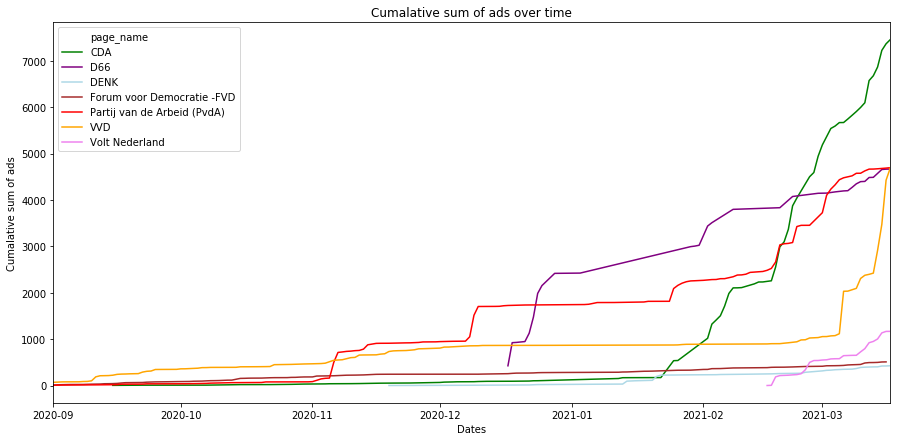

In [12]:
fig, ax = plt.subplots(figsize=(15,7))

size = top_7_party_ads.groupby(['page_name','ad_delivery_start_time']).size()

size = size.groupby('page_name').cumsum()

size = size.reset_index()

size.rename(columns={size.columns[2]: "ads_counter" }, inplace = True)

#size[size["page_name"]=='VVD']

ax.set_title("Cumalative sum of ads over time")

ax = sns.lineplot(ax=ax, data=size, x='ad_delivery_start_time', y='ads_counter', hue='page_name', palette=["green", "purple", "lightblue","brown", "red", "orange","violet"])
ax.set(xlabel='Dates', ylabel='Cumalative sum of ads')

ax.set_xlim('2020-09','2021-03-17')
ax.figure.savefig('test.png')



In [13]:
ax.set_title("Cumalative sum of ads over time")

ax = sns.lineplot(ax=ax, data=size, x='ad_delivery_start_time', y='ads_counter', hue='page_name')
ax.set(xlabel='Dates', ylabel='Cumalative sum of ads')

#plt.savefig('Ads_counter_dates.png', bbox_inches='tight')

#ax.set_xlim('2020-09','2021-03')


[Text(17.200000000000003, 0.5, 'Cumalative sum of ads'),
 Text(0.5, 17.200000000000003, 'Dates')]

Count the median impressions for political parties based on unique ads

In [14]:
impressions_ads_counter = df.groupby('page_name')['impressions_median'].sum()
impressions_ads_counter.sort_values

impressions_ads_counter_top_7 = top_7_party_ads.groupby('page_name').agg({'impressions_median':sum})
impressions_ads_counter_top_7.sort_values

<bound method DataFrame.sort_values of                              impressions_median
page_name                                      
CDA                                  63032772.5
D66                                  87507667.5
DENK                                  6902286.5
Forum voor Democratie -FVD           58882251.0
Partij van de Arbeid (PvdA)          30130152.0
VVD                                  52885154.5
Volt Nederland                       17437416.0>

Amount of ads per political party

In [15]:
df.page_name.value_counts().head(30)

CDA                            7457
Partij van de Arbeid (PvdA)    4696
VVD                            4693
D66                            4666
Volt Nederland                 1168
Forum voor Democratie -FVD      510
DENK                            427
SP                              350
GroenLinks                      339
50PLUSpartij                    167
BIJ1                            155
Partij voor de Dieren           128
JA21                            101
ChristenUnie                     69
BBB Boerburgerbeweging           65
SGP                              52
Name: page_name, dtype: int64

Count the amount of ads per political party with the same ad creative body (e.g. unique ads)

In [16]:
ads_counter = clean_ads.groupby('page_name')['ad_creative_body'].nunique()
ads_counter.sort_values()

top_7_party_ads_clean = clean_ads.loc[clean_ads['page_name'].isin(['VVD','CDA','D66','DENK','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

ads_counter_top_7 = top_7_party_ads_clean.groupby('page_name')['ad_creative_body'].nunique()
ads_counter_top_7.sort_values()

page_name
Volt Nederland                  34
D66                             41
DENK                            53
CDA                            134
Partij van de Arbeid (PvdA)    183
VVD                            259
Forum voor Democratie -FVD     369
Name: ad_creative_body, dtype: int64

Create plot for the ads counter

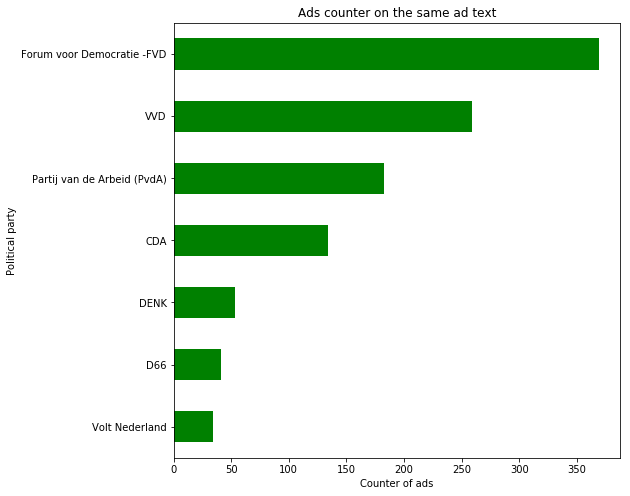

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
ads_counter_top_7.sort_values().plot.barh(x='ad_creative_body',
                      y='page_name',
                      ax=ax,
                      color="green")

ax.set_title("Ads counter on the same ad text")


plt.ylabel('Political party')
plt.xlabel('Counter of ads')
plt.savefig('Ads_counter_same_text.png', bbox_inches='tight')
plt.show()

## Create dataframe of precise ad spend numbers

In [19]:
# Compare fetched API ads to ad library report counts

#spend_ads = pd.DataFrame({'page_name': ['VVD','CDA','D66','GroenLinks','Partij van de Arbeid (PvdA)','ChristenUnie','50PLUSpartij','SGP','SP','Partij voor de Dieren','DENK','Forum voor Democratie -FVD','JA21','Volt Nederland','BBB Boerburgerbeweging','BIJ1'], 'total_spend': [347915,762155,342798,197687,181260,53194,12557,11926,162649,87061,34416,362374,64091,88038,26828,39615]})

page_name = ['VVD','CDA','D66','GroenLinks','Partij van de Arbeid (PvdA)','ChristenUnie','50PLUSpartij','SGP','SP','Partij voor de Dieren','DENK','Forum voor Democratie -FVD','JA21','Volt Nederland','BBB Boerburgerbeweging','BIJ1']
total_spend = [347915,762155,342798,197687,181260,53194,12557,11926,162649,87061,34416,362374,64091,88038,26828,39615]
spend_ads = pd.DataFrame({'total_spend': total_spend}, index=page_name)

#spend_ads = pd.DataFrame(spenditure)  
#spend_ads["total_spend"]=spend_ads["total_spend"].astype(float)

spend_ads.head(30)

,total_spend
VVD,347915
CDA,762155
D66,342798
GroenLinks,197687
Partij van de Arbeid (PvdA),181260
ChristenUnie,53194
50PLUSpartij,12557
SGP,11926
SP,162649
Partij voor de Dieren,87061


List of top 7

In [20]:
page_name_top7 = ['CDA','D66','DENK','Forum voor Democratie -FVD','Partij van de Arbeid (PvdA)','VVD','Volt Nederland']
total_spend_top7 = [762155,342798,34416,362374,181260,347915,88038]
spend_ads_top7 = pd.DataFrame({'total_spend': total_spend_top7}, index=page_name_top7)

Create plot for total spent on ads per political party

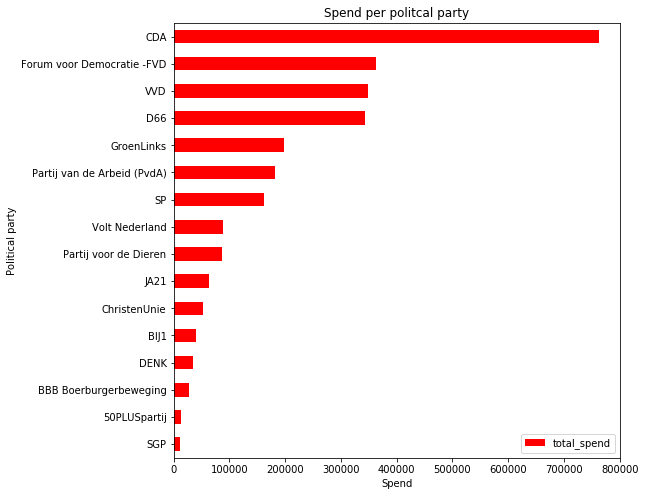

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
spend_ads.sort_values(by='total_spend').plot.barh(y='total_spend',
                      ax=ax,
                      color="red")

ax.set_title("Spend per politcal party")

plt.ylabel('Political party')
plt.xlabel('Spend')
plt.savefig('BoxPlot_Survey_Gender.png', bbox_inches='tight')
plt.show()

Create plot of top 7 spend

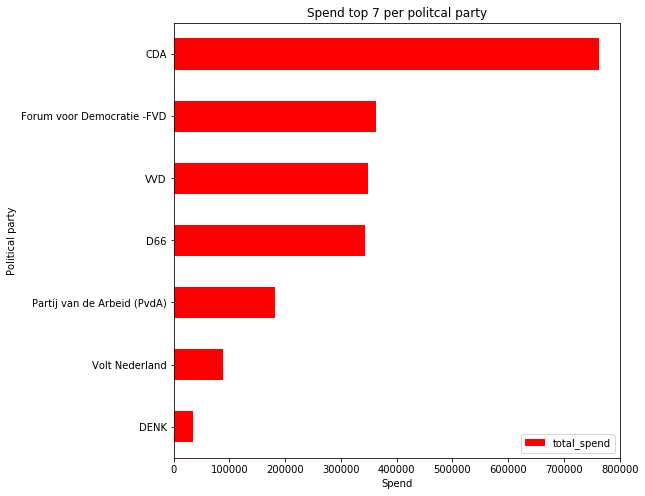

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
spend_ads_top7.sort_values(by='total_spend').plot.barh(y='total_spend',
                      ax=ax,
                      color="red")

ax.set_title("Spend top 7 per politcal party")

plt.ylabel('Political party')
plt.xlabel('Spend')
plt.savefig('Spend_party.png', bbox_inches='tight')
plt.show()

Succesrate based on impressions and spend

In [23]:
spend_top7 = spend_ads_top7.reset_index()
imp_top7 = impressions_ads_counter_top_7.reset_index()
spend_top7['impressions_median'] = imp_top7['impressions_median']
spend_top7['succesrate'] = spend_top7['impressions_median'] / spend_top7['total_spend']
spend_top7.head(10)

,index,total_spend,impressions_median,succesrate
0,CDA,762155,63032772.5,82.703351
1,D66,342798,87507667.5,255.274732
2,DENK,34416,6902286.5,200.554582
3,Forum voor Democratie -FVD,362374,58882251.0,162.490275
4,Partij van de Arbeid (PvdA),181260,30130152.0,166.226150
5,VVD,347915,52885154.5,152.005963
6,Volt Nederland,88038,17437416.0,198.066926


Create a dataframe to groupby on each unique ad and the targeted gender

In [24]:
demo_target = (demo
  .merge(clean_ads, on='ad_id')
)

demo_target = demo_target[demo_target.gender != 'unknown']

#gender_median
demo_target['gender_median'] = demo_target.groupby(['ad_id','page_name','gender'])['percentage'].transform('median')
#demo_target['gender_per'] = demo_target.groupby(['ad_id','page_name','gender'])['percentage']

#age_median
demo_target['age_median'] = demo_target.groupby(['ad_id','page_name','age'])['percentage'].transform('median')
#demo_target['age_per'] = demo_target.groupby(['ad_id','page_name','age'])['percentage']


hue_order_age = ['18-24', '25-34', '35-44','45-54','55-64','65+']

In [25]:
demo_target.head()

,ad_id,age,gender,percentage,page_id,page_name,ad_creative_body,ad_creative_link_caption,ad_creative_link_description,ad_creative_link_title,...,funding_entity,impressions_min,impressions_max,spend_min,spend_max,ad_url,spend_median,impressions_median,gender_median,age_median
0,145416310798679,45-54,female,0.092256,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,...,VVD,3000,3999.0,0,99,https://www.facebook.com/ads/library/?id=145416310798679,49.5,3499.5,0.065320,0.111111
1,145416310798679,35-44,male,0.123232,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,...,VVD,3000,3999.0,0,99,https://www.facebook.com/ads/library/?id=145416310798679,49.5,3499.5,0.106734,0.107070
2,145416310798679,18-24,female,0.039731,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,...,VVD,3000,3999.0,0,99,https://www.facebook.com/ads/library/?id=145416310798679,49.5,3499.5,0.065320,0.064983
3,145416310798679,35-44,female,0.090909,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,...,VVD,3000,3999.0,0,99,https://www.facebook.com/ads/library/?id=145416310798679,49.5,3499.5,0.065320,0.107070
4,145416310798679,18-24,male,0.090236,121264564551002,VVD,Bedankt voor je stem!\nWord lid. 👉 vvd.nl/word-lid,NaN,NaN,NaN,...,VVD,3000,3999.0,0,99,https://www.facebook.com/ads/library/?id=145416310798679,49.5,3499.5,0.106734,0.064983


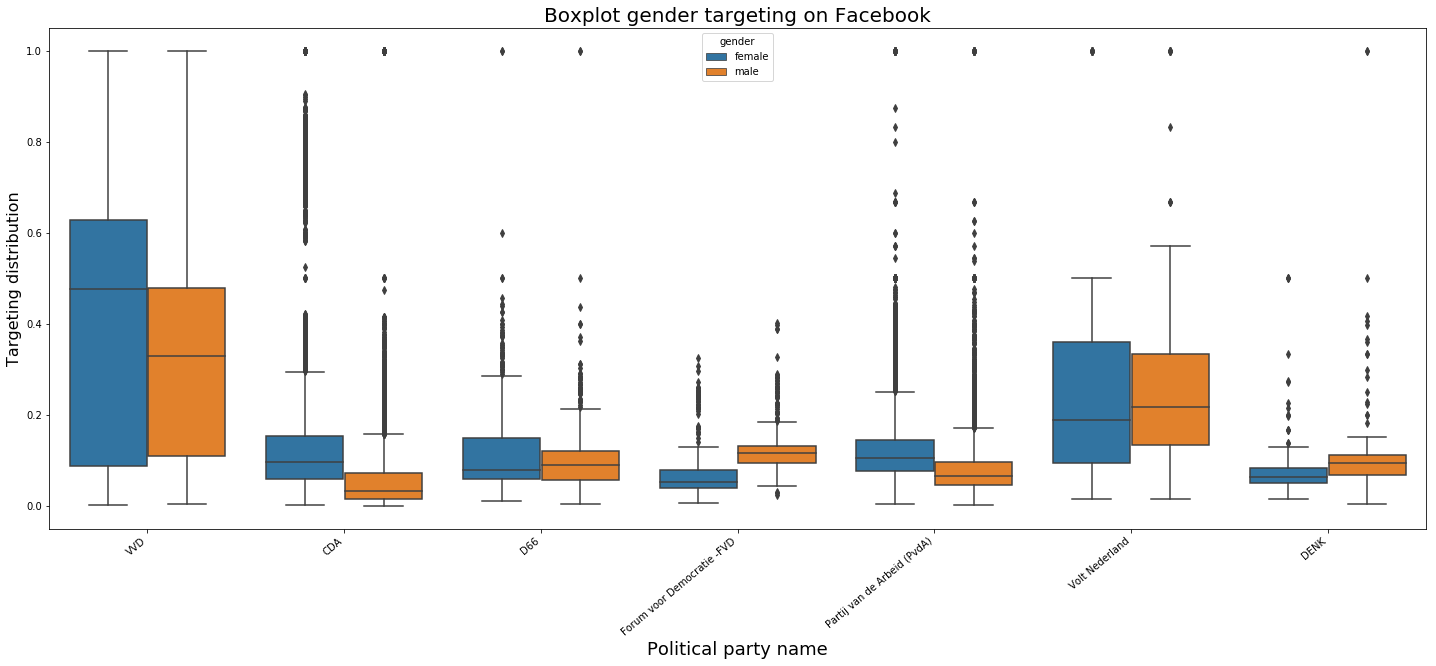

In [26]:
demo_target_unique = demo_target.drop_duplicates(subset = ["ad_id","gender"])
top_7_demo = demo_target_unique.loc[demo_target_unique['page_name'].isin(['VVD','CDA','D66','DENK','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

fig, ax = plt.subplots(figsize=(20, 9))

sns.boxplot(x="page_name", y="gender_median", hue="gender",
                 data=top_7_demo, ax=ax, order=['VVD','CDA','D66', 'Forum voor Democratie -FVD', 'Partij van de Arbeid (PvdA)','Volt Nederland','DENK'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Boxplot gender targeting on Facebook', fontsize=20)
plt.xlabel('Political party name', fontsize=18)
plt.ylabel('Targeting distribution', fontsize=16)

plt.savefig('BoxPlot_Facebook_Gender.png',bbox_inches='tight')

plt.show()

Create a dataframe to groupby on each unique ad and the targeted age

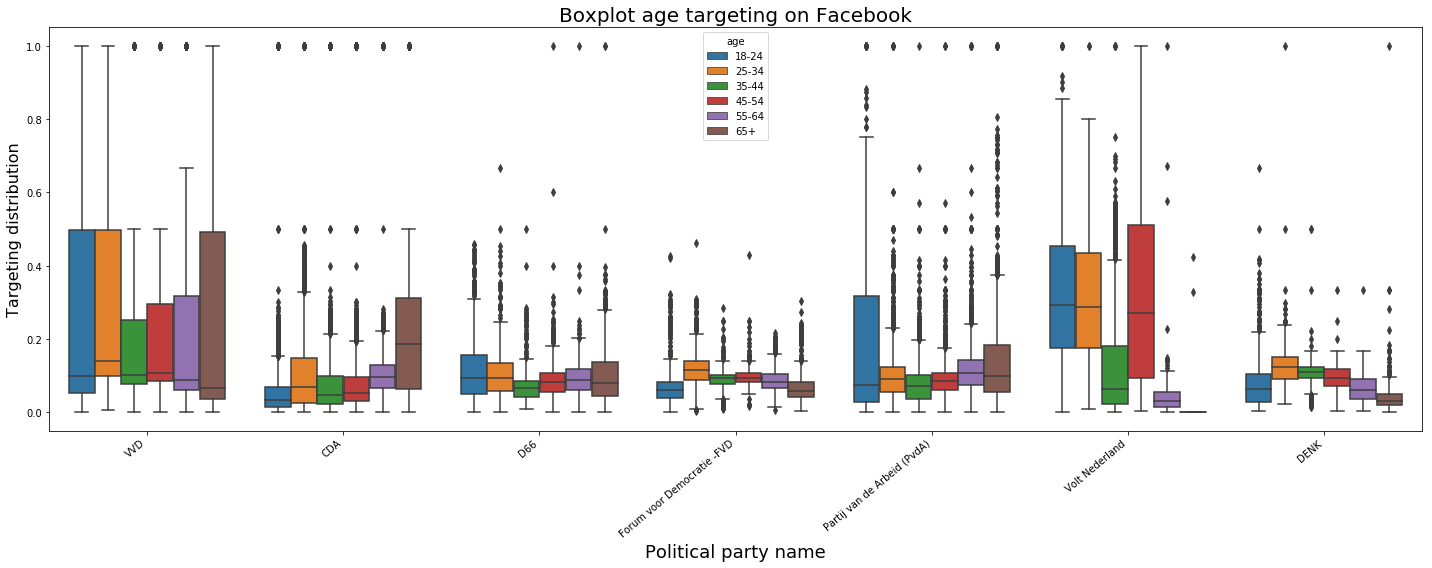

In [27]:
age_target = demo_target[demo_target.age != '13-17']
age_target_unique = age_target.drop_duplicates(subset = ["ad_id","age"])
top_7_age = age_target_unique.loc[age_target_unique['page_name'].isin(['VVD','CDA','D66','DENK','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

ax = plt.subplots(figsize=(20, 8))

ax = sns.boxplot(x="page_name", y="age_median", hue="age",
                 data=top_7_age, hue_order=hue_order_age, order=['VVD','CDA','D66', 'Forum voor Democratie -FVD', 'Partij van de Arbeid (PvdA)','Volt Nederland','DENK'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Boxplot age targeting on Facebook', fontsize=20)
plt.xlabel('Political party name', fontsize=18)
plt.ylabel('Targeting distribution', fontsize=16)
plt.tight_layout()
plt.savefig('BoxPlot_Facebook_Age.png', bbox_inches='tight')
plt.show()


In [28]:
demo_target_unique = demo_target.drop_duplicates(subset = ["ad_id","gender"])
age_target_unique = demo_target_unique.drop_duplicates(subset = ["ad_id","age"])

top_7 = age_target_unique.loc[age_target_unique['page_name'].isin(['VVD','CDA','D66','DENK','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

top_3_target = top_7.groupby(['ad_id''page_name','age','gender']).agg({'percentage':sum})
party_top = top_3_target['percentage'].groupby('page_name', group_keys=False)
res = party_top.apply(lambda x: x.sort_values(ascending=False).head(3))

KeyError: 'ad_idpage_name'

In [29]:
test1 = top_7.groupby(['page_name','gender']).agg({'percentage':sum})
test2 = test1.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

test3 = test2.apply(lambda x: x.sort_values(ascending=False))
# set labels)

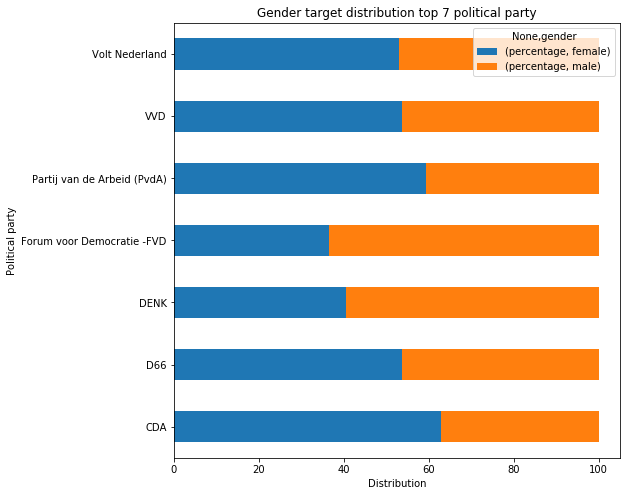

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
test3.unstack().plot.barh(stacked=True, title = 'Gender target percentages', mark_right = True, ax=ax)

ax.set_title("Gender target distribution top 7 political party")

plt.ylabel('Political party')
plt.xlabel('Distribution')
plt.savefig('Gender_dis_stacked.png', bbox_inches='tight')

plt.show()

Create a dataframe to groupby on each unique ad and the targeted region

In [34]:
geo_target = (geo
  .merge(clean_ads, on='ad_id')
)

geo_target = geo_target.loc[~geo_target['region'].isin(['Unknown','Niedersachsen','Flemish Region','Nordrhein-Westfalen','Mandalay'])]

geo_target['region_median'] = geo_target.groupby(['ad_id','page_name','region'])['percentage'].transform('median')

In [35]:
region_target_unique = geo_target.drop_duplicates(subset = ["ad_id","region"])
top_6_region = region_target_unique.loc[region_target_unique['page_name'].isin(['VVD','CDA','D66','DENK','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

In [36]:
top_3_target_region = top_6_region.groupby(['page_name','region']).agg({'percentage':sum})
party_top_region = top_3_target_region['percentage'].groupby('page_name', group_keys=False)
res_region = party_top_region.apply(lambda x: x.sort_values(ascending=False).head(3))

In [37]:
party_top_region.nlargest(6)

page_name                    region       
CDA                          North Brabant    908.824802
                             Gelderland       890.521747
                             Zuid-Holland     890.333690
                             Utrecht          870.603362
                             Noord-Holland    852.392961
                             Overijssel       792.712296
D66                          Zuid-Holland      83.273898
                             Noord-Holland     75.453371
                             North Brabant     67.531036
                             Gelderland        57.234978
                             Overijssel        35.617620
                             Limburg           33.977268
DENK                         Zuid-Holland     122.490645
                             Noord-Holland     76.428233
                             North Brabant     44.378173
                             Gelderland        38.131415
                             Utrecht         

In [38]:
top_7_prop = top_7[top_7.age != '13-17']
#top_6_prop = top_6[top_6.gender != 'unknown']
top_7_prop = top_7_prop.groupby(['page_name','age','gender'])['percentage'].size().unstack().reset_index()

top_7_prop['ads_count'] = (top_7_prop['female'] + top_7_prop['male'])

total_cda = top_7_prop.ads_count.iloc[0:6].sum()
total_d66 = top_7_prop.ads_count.iloc[6:12].sum()
total_denk = top_7_prop.ads_count.iloc[12:18].sum()
total_fvd = top_7_prop.ads_count.iloc[18:24].sum()
total_pvda = top_7_prop.ads_count.iloc[24:30].sum()
total_vvd = top_7_prop.ads_count.iloc[30:36].sum()
total_volt = top_7_prop.ads_count.iloc[36:42].sum()

top_7_prop.loc[top_7_prop.index[0:6], 'Ads_total'] = total_cda
top_7_prop.loc[top_7_prop.index[6:12], 'Ads_total'] = total_d66
top_7_prop.loc[top_7_prop.index[12:18], 'Ads_total'] = total_denk
top_7_prop.loc[top_7_prop.index[18:24], 'Ads_total'] = total_fvd
top_7_prop.loc[top_7_prop.index[24:30], 'Ads_total'] = total_pvda
top_7_prop.loc[top_7_prop.index[30:36], 'Ads_total'] = total_vvd
top_7_prop.loc[top_7_prop.index[36:42], 'Ads_total'] = total_volt

top_7_prop['target_prop'] = ((top_7_prop['female'] + top_7_prop['male'])) / top_7_prop['Ads_total']

top_7_prop

gender,page_name,age,female,male,ads_count,Ads_total,target_prop
0,CDA,18-24,1269,1225,2494,11924.0,0.209158
1,CDA,25-34,1108,986,2094,11924.0,0.175612
2,CDA,35-44,960,1013,1973,11924.0,0.165465
3,CDA,45-54,876,863,1739,11924.0,0.145840
4,CDA,55-64,685,838,1523,11924.0,0.127726
5,CDA,65+,1012,1089,2101,11924.0,0.176199
6,D66,18-24,50,74,124,830.0,0.149398
7,D66,25-34,90,69,159,830.0,0.191566
8,D66,35-44,77,72,149,830.0,0.179518
9,D66,45-54,62,70,132,830.0,0.159036


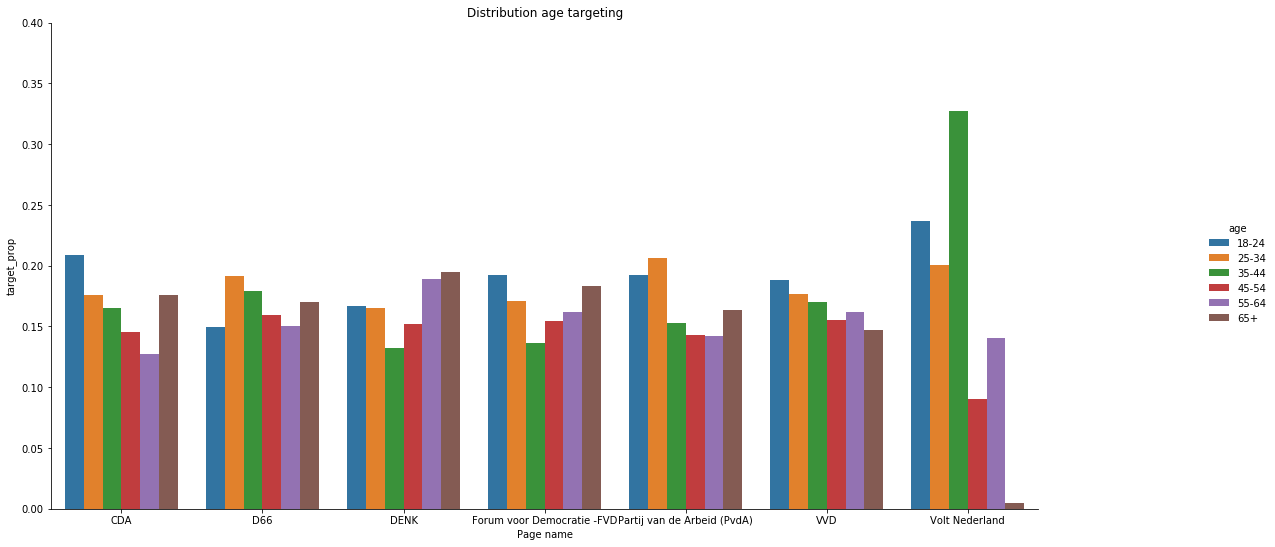

In [39]:
g = sns.catplot(x='page_name', y='target_prop', hue='age', kind='bar', data=top_7_prop)
g.fig.set_size_inches(20,8)
g.ax.set_ylim(0,0.4)

plt.title('Distribution age targeting')
plt.xlabel('Page name')

plt.savefig('Target percentage of total ads on age.png', bbox_inches='tight')

plt.show()

In [40]:
top_7_prop_gen = top_7[top_7.gender != 'unknown']
#top_6_prop_gen = top_6_prop_gen[top_6_prop_gen.age != '13-17']
top_7_prop_gen = top_7_prop_gen.groupby(['page_name','gender']).size().reset_index()

#top_6_prop_gen.rename(columns={"0": "total"})

top_7_prop_gen.columns = ['page_name', 'gender', 'total']

#top_6_prop_gen

total_cda = top_7_prop_gen.total.iloc[0:2].sum()
total_d66 = top_7_prop_gen.total.iloc[2:4].sum()
total_denk = top_7_prop_gen.total.iloc[4:6].sum()
total_fvd = top_7_prop_gen.total.iloc[6:8].sum()
total_pvda = top_7_prop_gen.total.iloc[8:10].sum()
total_vvd = top_7_prop_gen.total.iloc[10:12].sum()
total_volt = top_7_prop_gen.total.iloc[12:14].sum()

top_7_prop_gen.loc[top_7_prop_gen.index[0:2], 'Ads_total'] = total_cda
top_7_prop_gen.loc[top_7_prop_gen.index[2:4], 'Ads_total'] = total_d66
top_7_prop_gen.loc[top_7_prop_gen.index[4:6], 'Ads_total'] = total_denk
top_7_prop_gen.loc[top_7_prop_gen.index[6:8], 'Ads_total'] = total_fvd
top_7_prop_gen.loc[top_7_prop_gen.index[8:10], 'Ads_total'] = total_pvda
top_7_prop_gen.loc[top_7_prop_gen.index[10:12], 'Ads_total'] = total_vvd
top_7_prop_gen.loc[top_7_prop_gen.index[12:14], 'Ads_total'] = total_volt


top_7_prop_gen['target_prop_gen'] = top_7_prop_gen['total'] / top_7_prop_gen['Ads_total']

top_7_prop_gen

,page_name,gender,total,Ads_total,target_prop_gen
0,CDA,female,5910,11924.0,0.495639
1,CDA,male,6014,11924.0,0.504361
2,D66,female,415,830.0,0.500000
3,D66,male,415,830.0,0.500000
4,DENK,female,358,713.0,0.502104
5,DENK,male,355,713.0,0.497896
6,Forum voor Democratie -FVD,female,439,889.0,0.493813
7,Forum voor Democratie -FVD,male,450,889.0,0.506187
8,Partij van de Arbeid (PvdA),female,3291,6552.0,0.502289
9,Partij van de Arbeid (PvdA),male,3261,6552.0,0.497711


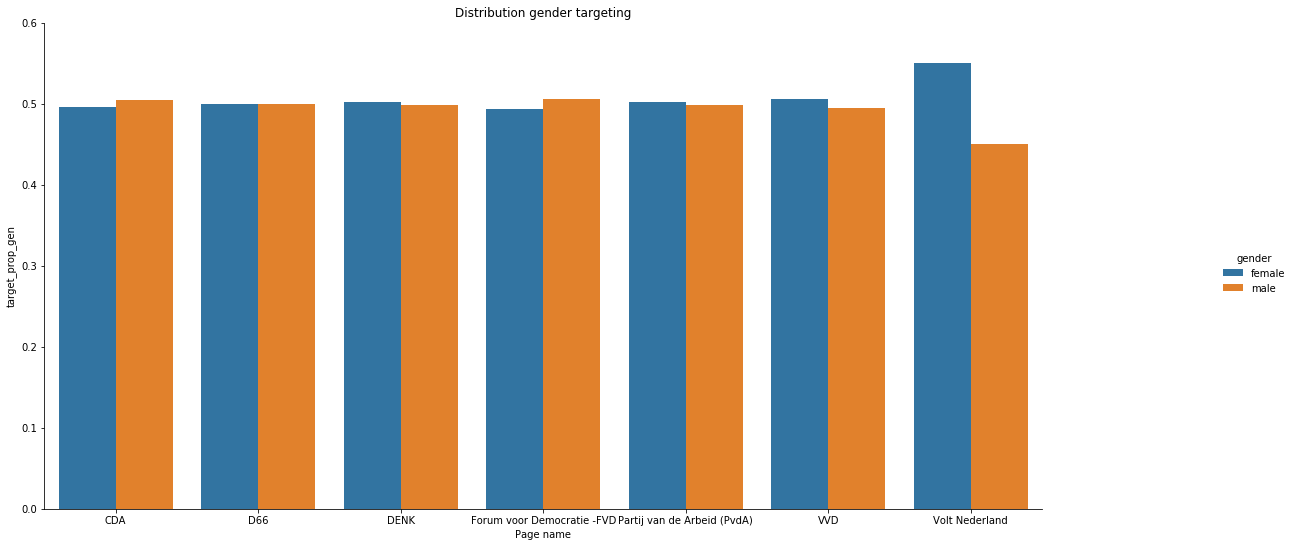

In [41]:
g = sns.catplot(x='page_name', y='target_prop_gen', hue='gender', kind='bar', data=top_7_prop_gen)
g.fig.set_size_inches(20,8)
g.ax.set_ylim(0,0.6)

plt.title('Distribution gender targeting')
plt.xlabel('Page name')
plt.savefig('Target percentage of total ads on gender.png', bbox_inches='tight')

plt.show()

## Start of A/B analysis

### We will look at ads that have duplicate on the following rows: 
-Page ID
-Page name (name of political party)
-Ad Creative Body (text in ad)
-Ad delivery start time (date when the ad was life
-Ad delivery stop time (date when the ad wasn't life)
-Ad creation time (date when ad was created, important, since a/b ads needs to be created on the same date)
-Spend min (minimum payment for ad)
-Spend max (maximum payment for ad)

In [42]:
a_b_ads = clean_ads[clean_ads.duplicated(['page_id','ad_creative_body','ad_delivery_start_time','ad_delivery_stop_time','ad_creation_time','spend_min','spend_max'])]
a_b_ads[['ad_id','page_id','page_name','ad_creative_body','ad_delivery_start_time','ad_delivery_stop_time','ad_creation_time','spend_min','spend_max']].head()

,ad_id,page_id,page_name,ad_creative_body,ad_delivery_start_time,ad_delivery_stop_time,ad_creation_time,spend_min,spend_max
6,234527865065318,121264564551002,VVD,Bedankt voor je stem. Word lid!,2021-03-17,2021-03-29,2021-03-16,100,199
15,436282764101843,121264564551002,VVD,Bedankt voor je stem. Word lid!,2021-03-17,2021-03-29,2021-03-16,100,199
16,453866019260063,121264564551002,VVD,Bedankt voor je stem. Word lid!,2021-03-17,2021-03-29,2021-03-16,100,199
24,928156534599271,121264564551002,VVD,Bedankt voor je stem.\nWord lid! 👉 vvd.nl/word-lid,2021-03-17,2021-03-22,2021-03-17,0,99
25,1323208774720490,121264564551002,VVD,Bedankt voor je stem.\nWord lid! 👉 vvd.nl/word-lid,2021-03-17,2021-03-22,2021-03-17,0,99


Amount of ads with duplicate values

In [43]:
len(a_b_ads)

15549

In [44]:
top_7_party_ads_ab = a_b_ads.loc[a_b_ads['page_name'].isin(['VVD','CDA','D66','DENK','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]
len(top_7_party_ads_ab)

15317

Amount of duplicate ads per political party

In [45]:
top_7_party_ads_ab.page_name.value_counts().head(30)

CDA                            5809
VVD                            3791
Partij van de Arbeid (PvdA)    3332
D66                            1235
Volt Nederland                  863
DENK                            265
Forum voor Democratie -FVD       22
Name: page_name, dtype: int64

Count the amount of ads per political party with the same ad creative body

In [46]:
ab_ads_counter = top_7_party_ads_ab.groupby('page_name')['ad_creative_body'].nunique()
ab_ads_counter.sort_values()

page_name
Forum voor Democratie -FVD      12
D66                             31
Volt Nederland                  32
DENK                            43
Partij van de Arbeid (PvdA)     80
CDA                            105
VVD                            166
Name: ad_creative_body, dtype: int64

Create plot for the ads counter

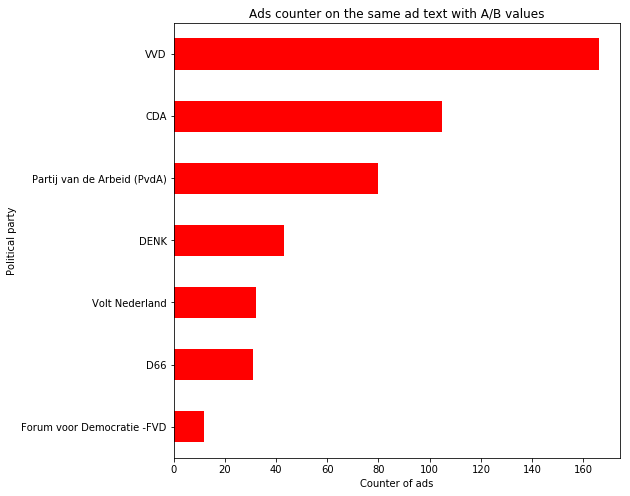

In [47]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
ab_ads_counter.sort_values().plot.barh(x='ad_creative_body',
                      y='page_name',
                      ax=ax,
                      color="red")

ax.set_title("Ads counter on the same ad text with A/B values")

plt.ylabel('Political party')
plt.xlabel('Counter of ads')
plt.savefig('Ads counter same ad text ab.png', bbox_inches='tight')

plt.show()

Create plot with the a/b ads distribution over time

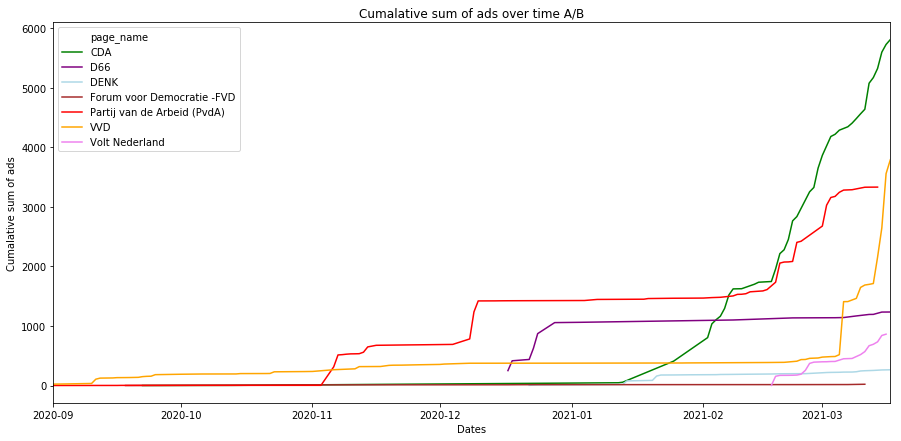

In [50]:
fig, ax = plt.subplots(figsize=(15,7))

size2 = top_7_party_ads_ab.groupby(['page_name','ad_delivery_start_time']).size()

size2 = size2.groupby('page_name').cumsum()

size2 = size2.reset_index()

size2.rename(columns={size2.columns[2]: "ads_counter" }, inplace = True)

#size[size["page_name"]=='VVD']

ax.set_title("Cumalative sum of ads over time A/B")

ax = sns.lineplot(ax=ax, data=size2, x='ad_delivery_start_time', y='ads_counter', hue='page_name', palette=["green", "purple", "lightblue","brown", "red", "orange","violet"])
ax.set(xlabel='Dates', ylabel='Cumalative sum of ads')

ax.set_xlim('2020-09','2021-03-17')
ax.figure.savefig('test123.png')



In [51]:
len(a_b_ads["ad_creative_body"].unique())

544

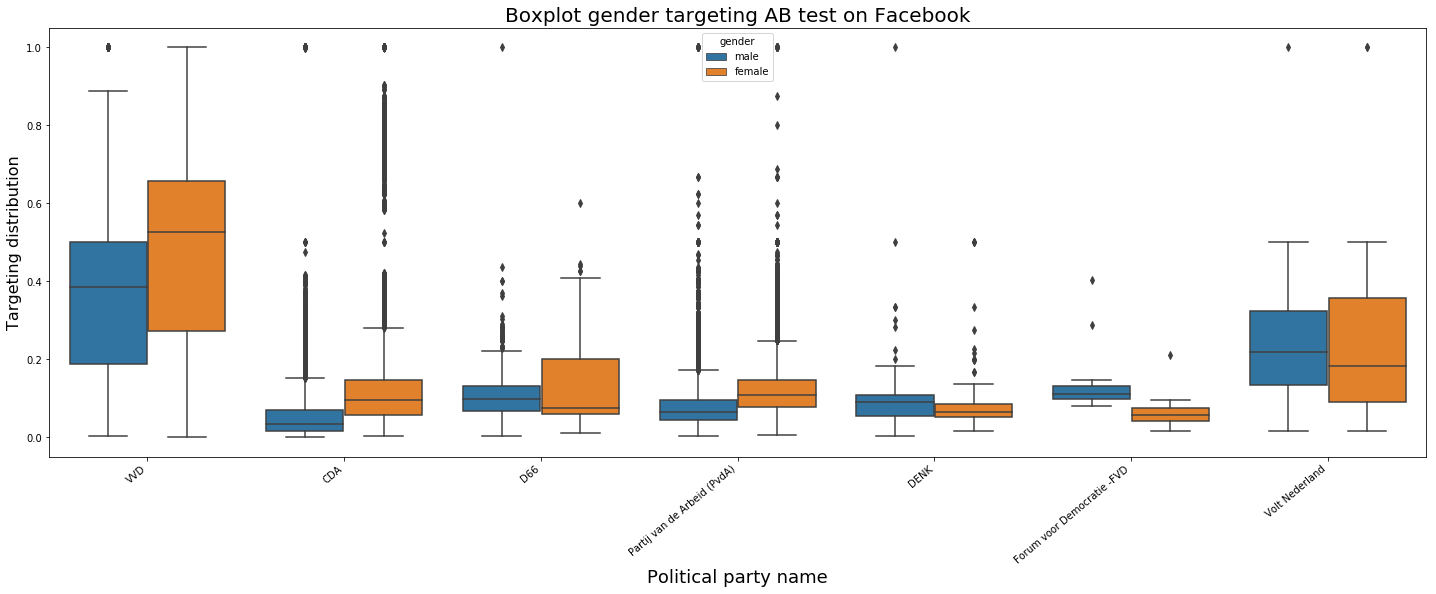

In [52]:
demo_target_ab = (demo
  .merge(top_7_party_ads_ab, on='ad_id')
)

#gender_median
demo_target_ab['gender_median'] = demo_target_ab.groupby(['ad_id','page_name','gender'])['percentage'].transform('median')

demo_target_ab = demo_target_ab[demo_target_ab.gender != 'unknown']
gender_target_ab_unique = demo_target_ab.drop_duplicates(subset = ["ad_id","gender"])

##top_6_demo_ab = gender_target_ab_unique.loc[gender_target_ab_unique['page_name'].isin(['VVD','CDA','D66','GroenLinks','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

ax = plt.subplots(figsize=(20, 8))

ax = sns.boxplot(x="page_name", y="gender_median", hue="gender",
                 data=gender_target_ab_unique)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Boxplot gender targeting AB test on Facebook', fontsize=20)
plt.xlabel('Political party name', fontsize=18)
plt.ylabel('Targeting distribution', fontsize=16)
plt.savefig('Boxplot gender ab.png', bbox_inches='tight')
plt.show()

#demo_target.groupby(['ad_id','page_name','gender']).boxplot(column='page_name', by='percentage')

#gender_target_df = demo_target.groupby(['ad_id','page_name','gender']).agg('percentage')
#gender_target_df.head()
#gender_target_df.to_csv (r'gender_test.csv', index = False, header=True)

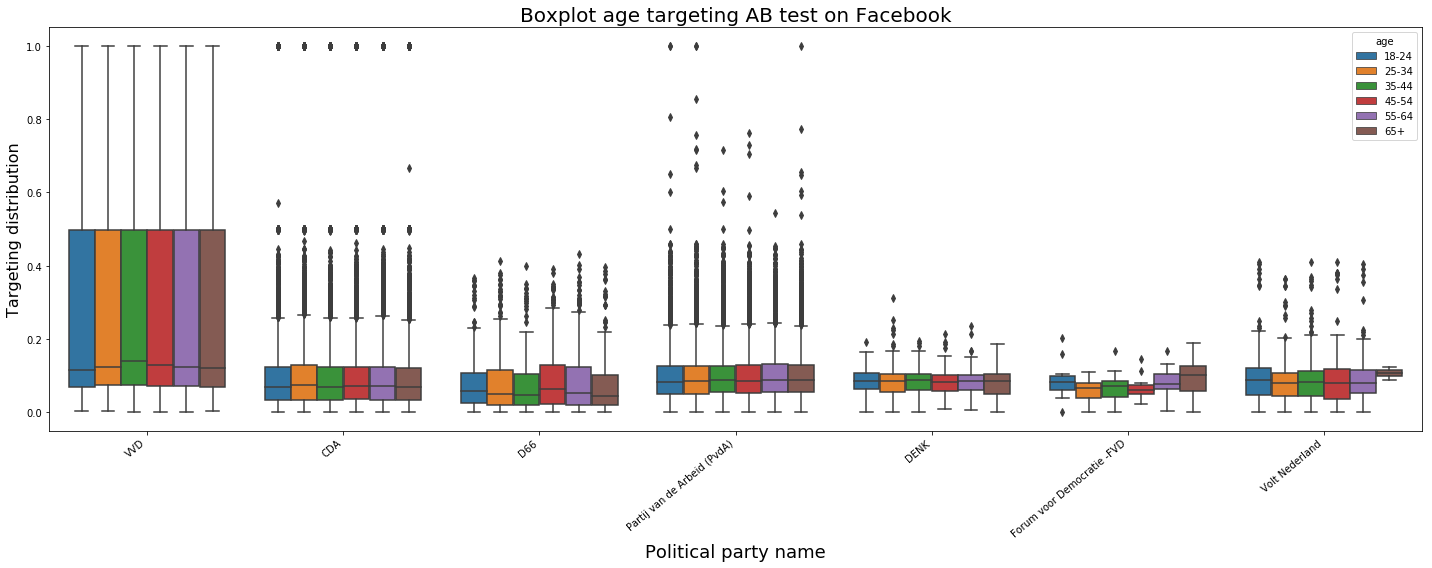

In [53]:
#age_median
demo_target_ab['age_median'] = demo_target.groupby(['ad_id','page_name','age'])['percentage'].transform('median')

age_target_ab = demo_target_ab[demo_target_ab.age != '13-17']
age_target_ab_unique = age_target_ab.drop_duplicates(subset = ["ad_id","age"])

#top_6_age_ab = age_target_ab_unique.loc[age_target_ab_unique['page_name'].isin(['VVD','CDA','D66','GroenLinks','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

ax = plt.subplots(figsize=(20, 8))

ax = sns.boxplot(x="page_name", y="age_median", hue="age",
                 data=age_target_ab_unique, hue_order=hue_order_age)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Boxplot age targeting AB test on Facebook', fontsize=20)
plt.xlabel('Political party name', fontsize=18)
plt.ylabel('Targeting distribution', fontsize=16)
plt.tight_layout()
plt.savefig('Boxplot age ab.png', bbox_inches='tight')
plt.show()

#age_target_df = demo_target.groupby(['ad_id','page_name','age']).agg({'percentage': 'sum'})
#age_target_df.head()

In [55]:
party_top_ab.nlargest(5)

page_name                    age    gender
CDA                          65+    female    288.274758
                             25-34  female    206.838064
                             65+    male      155.968936
                             18-24  female    139.930643
                             45-54  female    138.863744
D66                          18-24  female      8.699440
                             25-34  female      8.246563
                             18-24  male        7.624222
                             35-44  female      7.360938
                             25-34  male        6.853684
DENK                         25-34  male        4.799272
                             35-44  male        4.384945
                             18-24  female      4.300716
                             45-54  male        3.551346
                             25-34  female      3.514225
Forum voor Democratie -FVD   18-24  male        0.765526
                             45-54  male     

In [56]:
geo_target_ab = (geo
  .merge(top_7_party_ads_ab, on='ad_id')
)

geo_target_ab = geo_target_ab.loc[~geo_target_ab['region'].isin(['Unknown','Niedersachsen','Flemish Region','Nordrhein-Westfalen','Mandalay'])]

geo_target_ab['region_median'] = geo_target_ab.groupby(['ad_id','page_name','region'])['percentage'].transform('median')

In [57]:
region_target_unique_ab = geo_target_ab.drop_duplicates(subset = ["ad_id","region"])
#top_6_region_ab = region_target_unique_ab.loc[region_target_unique_ab['page_name'].isin(['VVD','CDA','D66','GroenLinks','Partij van de Arbeid (PvdA)','Forum voor Democratie -FVD','Volt Nederland'])]

In [58]:
top_3_target_region_ab = region_target_unique_ab.groupby(['page_name','region']).agg({'percentage':sum})
party_top_region_ab = top_3_target_region_ab['percentage'].groupby('page_name', group_keys=False)
res_region_ab = party_top_region_ab.apply(lambda x: x.sort_values(ascending=False).head(3))

In [59]:
party_top_region_ab.nlargest(5)

page_name                    region       
CDA                          Gelderland       751.580102
                             North Brabant    725.542975
                             Zuid-Holland     676.068920
                             Noord-Holland    673.900804
                             Utrecht          672.756625
D66                          Zuid-Holland      62.694371
                             Noord-Holland     57.936103
                             North Brabant     51.026565
                             Gelderland        43.220102
                             Utrecht           26.219892
DENK                         Zuid-Holland      80.996365
                             Noord-Holland     52.342794
                             North Brabant     30.824085
                             Gelderland        26.169971
                             Utrecht           21.799799
Forum voor Democratie -FVD   Zuid-Holland       5.142262
                             Noord-Holland   

In [60]:
top_7_prop_ab = age_target_ab_unique[age_target_ab_unique.age != '13-17']
#top_6_prop = top_6[top_6.gender != 'unknown']
top_7_prop_ab = top_7_prop_ab.groupby(['page_name','age','gender'])['percentage'].size().unstack().reset_index()

top_7_prop_ab['ads_count'] = (top_7_prop_ab['female'] + top_7_prop_ab['male'])

total_cda = top_7_prop_ab.ads_count.iloc[0:6].sum()
total_d66 = top_7_prop_ab.ads_count.iloc[6:12].sum()
total_denk = top_7_prop_ab.ads_count.iloc[12:18].sum()
total_fvd = top_7_prop_ab.ads_count.iloc[18:24].sum()
total_pvda = top_7_prop_ab.ads_count.iloc[24:30].sum()
total_vvd = top_7_prop_ab.ads_count.iloc[30:36].sum()
total_volt = top_7_prop_ab.ads_count.iloc[36:42].sum()

top_7_prop_ab.loc[top_7_prop_ab.index[0:6], 'Ads_total'] = total_cda
top_7_prop_ab.loc[top_7_prop_ab.index[6:12], 'Ads_total'] = total_d66
top_7_prop_ab.loc[top_7_prop_ab.index[12:18], 'Ads_total'] = total_denk
top_7_prop_ab.loc[top_7_prop_ab.index[18:24], 'Ads_total'] = total_fvd
top_7_prop_ab.loc[top_7_prop_ab.index[24:30], 'Ads_total'] = total_pvda
top_7_prop_ab.loc[top_7_prop_ab.index[30:36], 'Ads_total'] = total_vvd
top_7_prop_ab.loc[top_7_prop_ab.index[36:42], 'Ads_total'] = total_volt

top_7_prop_ab['target_prop'] = ((top_7_prop_ab['female'] + top_7_prop_ab['male'])) / top_7_prop_ab['Ads_total']

top_7_prop_ab

gender,page_name,age,female,male,ads_count,Ads_total,target_prop
0,CDA,18-24,957,989,1946,9545.0,0.203876
1,CDA,25-34,857,808,1665,9545.0,0.174437
2,CDA,35-44,781,846,1627,9545.0,0.170456
3,CDA,45-54,718,699,1417,9545.0,0.148455
4,CDA,55-64,553,696,1249,9545.0,0.130854
5,CDA,65+,815,826,1641,9545.0,0.171922
6,D66,18-24,40,59,99,628.0,0.157643
7,D66,25-34,72,57,129,628.0,0.205414
8,D66,35-44,57,55,112,628.0,0.178344
9,D66,45-54,45,47,92,628.0,0.146497


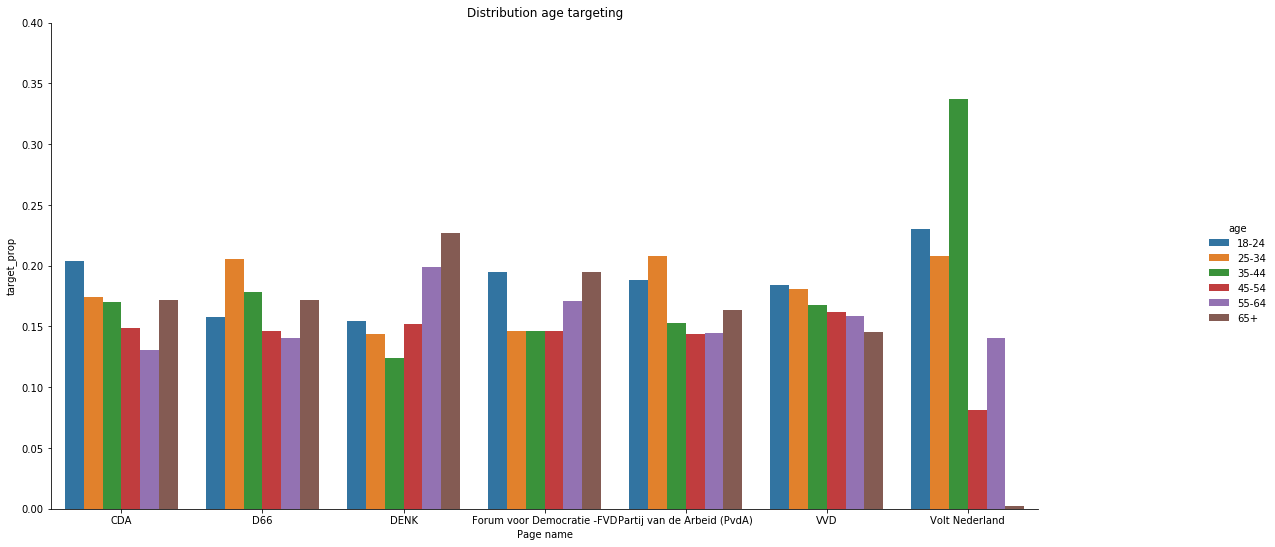

In [61]:
g = sns.catplot(x='page_name', y='target_prop', hue='age', kind='bar', data=top_7_prop_ab)
g.fig.set_size_inches(20,8)
g.ax.set_ylim(0,0.4)

plt.title('Distribution age targeting')
plt.xlabel('Page name')
plt.savefig('Target percentage of total ab ads on age.png', bbox_inches='tight')
plt.show()

In [62]:
top_7_prop_gen_ab = gender_target_ab_unique[gender_target_ab_unique.gender != 'unknown']
#top_6_prop_gen = top_6_prop_gen[top_6_prop_gen.age != '13-17']
top_7_prop_gen_ab = top_7_prop_gen_ab.groupby(['page_name','gender']).size().reset_index()

#top_6_prop_gen.rename(columns={"0": "total"})

top_7_prop_gen_ab.columns = ['page_name', 'gender', 'total']

#top_6_prop_gen

total_cda = top_7_prop_gen_ab.total.iloc[0:2].sum()
total_d66 = top_7_prop_gen_ab.total.iloc[2:4].sum()
total_denk = top_7_prop_gen_ab.total.iloc[4:6].sum()
total_fvd = top_7_prop_gen_ab.total.iloc[6:8].sum()
total_pvda = top_7_prop_gen_ab.total.iloc[8:10].sum()
total_vvd = top_7_prop_gen_ab.total.iloc[10:12].sum()
total_volt = top_7_prop_gen_ab.total.iloc[12:14].sum()

top_7_prop_gen_ab.loc[top_7_prop_gen_ab.index[0:2], 'Ads_total'] = total_cda
top_7_prop_gen_ab.loc[top_7_prop_gen_ab.index[2:4], 'Ads_total'] = total_d66
top_7_prop_gen_ab.loc[top_7_prop_gen_ab.index[4:6], 'Ads_total'] = total_denk
top_7_prop_gen_ab.loc[top_7_prop_gen_ab.index[6:8], 'Ads_total'] = total_fvd
top_7_prop_gen_ab.loc[top_7_prop_gen_ab.index[8:10], 'Ads_total'] = total_pvda
top_7_prop_gen_ab.loc[top_7_prop_gen_ab.index[10:12], 'Ads_total'] = total_vvd
top_7_prop_gen_ab.loc[top_7_prop_gen_ab.index[12:14], 'Ads_total'] = total_volt


top_7_prop_gen_ab['target_prop_gen'] = top_7_prop_gen_ab['total'] / top_7_prop_gen_ab['Ads_total']

top_7_prop_gen_ab

,page_name,gender,total,Ads_total,target_prop_gen
0,CDA,female,5452,10825.0,0.503649
1,CDA,male,5373,10825.0,0.496351
2,D66,female,360,720.0,0.500000
3,D66,male,360,720.0,0.500000
4,DENK,female,264,527.0,0.500949
5,DENK,male,263,527.0,0.499051
6,Forum voor Democratie -FVD,female,22,44.0,0.500000
7,Forum voor Democratie -FVD,male,22,44.0,0.500000
8,Partij van de Arbeid (PvdA),female,3313,6541.0,0.506497
9,Partij van de Arbeid (PvdA),male,3228,6541.0,0.493503


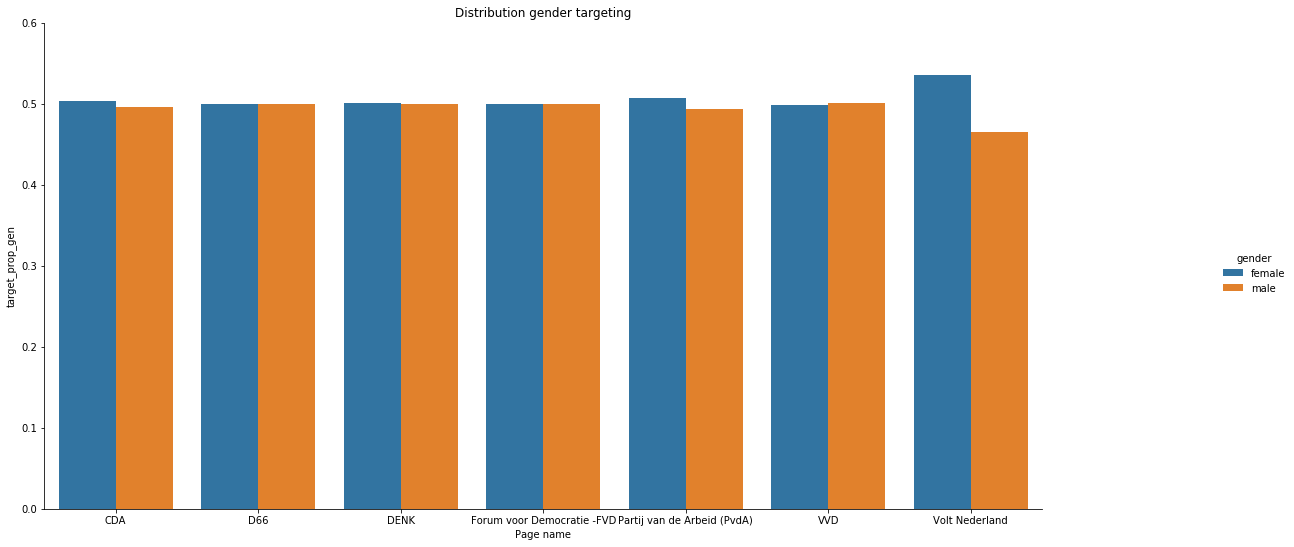

In [63]:
g = sns.catplot(x='page_name', y='target_prop_gen', hue='gender', kind='bar', data=top_7_prop_gen_ab)
g.fig.set_size_inches(20,8)
g.ax.set_ylim(0,0.6)

plt.title('Distribution gender targeting')
plt.xlabel('Page name')
plt.savefig('Target_percentage_of_total_ab_ads_on_gender.png', bbox_inches='tight')

plt.show()

# Word analysis

In [64]:
clean_ads_words = clean_ads_top7.drop_duplicates(subset=['ad_creative_body'])
slogan = ['samen', 'sterker' ,'verder', 'voor een eerlijke toekomst', 'doorpakken', 'stem voor nieuw', 'leiderschap', 'samen zijn wij nederland', 'stem nederland terug', 'toekomst made in europe', 'fvd', 'vvd']



In [65]:
!pip3 install -U textblob

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [66]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import itertools
import collections
import networkx as nx
import random
from random import randrange


#from textblob import TextBlob


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


# Load stopword lists for Dutch
stop_nl = set(stopwords.words('dutch'))

# Create column with normalized tokens
text = (clean_ads_top7.ad_creative_body
        .fillna('')
        .str.lower()
        .str.replace('[^\w\s]','')
        .apply(lambda x:  ' '.join([word for word in x.split() if pd.notna(x) and word not in stop_nl]))
        .apply(lambda x:  ' '.join([word for word in x.split() if pd.notna(x) and word not in slogan]))

        .apply(word_tokenize)
       )

clean_ads_words['tokens'] = text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Yossigijrath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Yossigijrath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/Yossigijrath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [67]:
from collections import Counter

all_tokens = [a for b in clean_ads_words.tokens.tolist() for a in b]
#all_tokens['count'] = counter
Counter(all_tokens).most_common(11)

[('we', 431),
 ('nederland', 288),
 ('onze', 195),
 ('stem', 178),
 ('wij', 138),
 ('17', 130),
 ('maart', 130),
 ('fvdnlja', 118),
 ('mensen', 109),
 ('gaan', 92),
 ('moeten', 90)]

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a column with the joined tokens as a single string
clean_ads_words['tokens_str'] = clean_ads_words.tokens.apply(lambda x: ' '.join(x))

word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(clean_ads_words.tokens_str)
frequencies = sum(sparse_matrix).toarray()[0]
ngrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values('frequency', ascending = False)

/Users/Yossigijrath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [69]:
ngrams[ngrams.index.str.contains(' ')].head(10)

,frequency
17 maart,128
thierry baudet,49
stem 17,48
tweede kamer,41
mark rutte,38
forum democratie,33
16 17,33
15 16,33
lilianne ploumen,32
stem denk,31


In [72]:
geo_clean = geo.loc[~geo['region'].isin(['Unknown','Niedersachsen','Flemish Region','Nordrhein-Westfalen','Mandalay','Wallonia','Bonaire, Sint Eustatius and Saba'])]

province_words = pd.DataFrame(columns = sorted(geo_clean.region.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_words[clean_ads_words.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,we,we,we,we,we,we,we,we,we,we,we,we
1,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland
2,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze
3,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem
4,wij,wij,wij,wij,wij,wij,wij,wij,wij,wij,wij,wij
5,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja,fvdnlja
6,17,17,17,17,17,17,17,17,17,17,17,17
7,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart
8,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen
9,weer,gaan,weer,moeten,weer,gaan,gaan,weer,gaan,weer,gaan,weer


In [73]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_words[clean_ads_words.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,we,we
1,nederland,nederland
2,onze,onze
3,stem,stem
4,wij,wij
5,maart,maart
6,17,17
7,fvdnlja,fvdnlja
8,mensen,mensen
9,gaan,gaan


In [74]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_words[clean_ads_words.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(15)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,we,we,we,we,we,we
1,nederland,nederland,nederland,nederland,nederland,nederland
2,onze,onze,onze,onze,onze,onze
3,stem,stem,stem,stem,stem,stem
4,wij,wij,wij,wij,wij,fvdnlja
5,maart,maart,17,fvdnlja,fvdnlja,wij
6,17,17,maart,maart,maart,mensen
7,fvdnlja,fvdnlja,fvdnlja,17,17,maart
8,mensen,mensen,mensen,mensen,mensen,17
9,gaan,gaan,gaan,gaan,gaan,gaan


### VVD 

In [75]:
geo_clean = geo.loc[~geo['region'].isin(['Unknown','Niedersachsen','Flemish Region','Nordrhein-Westfalen','Mandalay','Wallonia','Bonaire, Sint Eustatius and Saba'])]

province_words = pd.DataFrame(columns = sorted(geo_clean.region.unique()))

clean_ads_vvd = clean_ads_words.loc[clean_ads_words['page_name'] == 'VVD']

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_vvd[clean_ads_vvd.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words


,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,we,we,we,we,we,we,we,we,we,we,we,we
1,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze
2,kernenergie,kernenergie,nederland,nederland,kernenergie,nederland,nederland,nederland,nederland,kernenergie,kernenergie,nederland
3,nederland,nederland,kernenergie,kernenergie,wij,kernenergie,kernenergie,kernenergie,kernenergie,wij,nederland,kernenergie
4,wij,wij,wij,wij,nederland,wij,wij,wij,wij,nederland,wij,wij
5,mark,mark,mark,mark,willen,mark,mark,mark,mark,mark,mark,mark
6,willen,willen,willen,willen,mark,willen,willen,willen,willen,willen,willen,willen
7,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen
8,rutte,rutte,rutte,word,rutte,rutte,rutte,word,rutte,word,rutte,rutte
9,word,moeten,word,rutte,word,moeten,word,rutte,word,rutte,word,word


In [76]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_vvd[clean_ads_vvd.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,we,we
1,onze,onze
2,nederland,nederland
3,kernenergie,kernenergie
4,wij,wij
5,mark,mark
6,willen,willen
7,word,word
8,bouwen,bouwen
9,rutte,rutte


In [77]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_vvd[clean_ads_vvd.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(15)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,we,we,we,we,we,we
1,onze,onze,onze,onze,onze,onze
2,nederland,nederland,nederland,nederland,nederland,nederland
3,kernenergie,kernenergie,kernenergie,wij,wij,wij
4,wij,wij,wij,kernenergie,kernenergie,kernenergie
5,mark,mark,mark,mark,mark,mark
6,willen,willen,willen,word,word,willen
7,word,word,word,willen,willen,word
8,bouwen,bouwen,bouwen,bouwen,bouwen,bouwen
9,rutte,rutte,rutte,mee,mee,rutte


### CDA 

In [78]:
clean_ads_cda = clean_ads_words.loc[clean_ads_words['page_name'] == 'CDA']

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_cda[clean_ads_cda.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,nederland,we,nederland,nederland,we,we,stem,nederland,we,we,we,nederland
1,we,onze,we,we,nederland,nederland,we,cda,onze,cda,onze,cda
2,onze,nederland,onze,onze,onze,onze,onze,we,nederland,stem,nederland,we
3,cda,cda,cda,cda,cda,cda,nederland,onze,cda,nederland,economie,onze
4,moeten,pieter,kamerlid,moeten,moeten,gaan,cda,kamerlid,gaan,onze,ondernemers,economie
5,economie,omtzigt,moeten,economie,economie,huizen,jouw,stem,wopke,gaan,cda,pieter
6,ondernemers,moeten,ondernemers,ondernemers,ondernemers,ondernemers,wopke,gaan,stem,moeten,moeten,omtzigt
7,gaan,gaan,economie,kamerlid,gaan,kamerlid,hoekstra,ondernemers,hoekstra,economie,gaan,gaan
8,pieter,economie,kandidaat,gaan,pieter,moeten,garandeer,economie,samenleving,pieter,pieter,kamerlid
9,omtzigt,tijd,beter,pieter,omtzigt,daarom,veilig,kerstboodschap,moeten,omtzigt,omtzigt,moeten


In [79]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_cda[clean_ads_cda.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,we,we
1,stem,stem
2,onze,nederland
3,cda,cda
4,nederland,onze
5,hoekstra,hoekstra
6,wopke,wopke
7,gaan,gaan
8,moeten,moeten
9,huizen,tijd


In [80]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_cda[clean_ads_cda.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(15)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,we,we,we,we,we,we
1,stem,stem,stem,stem,stem,stem
2,onze,nederland,nederland,cda,cda,cda
3,hoekstra,cda,cda,onze,onze,nederland
4,wopke,hoekstra,hoekstra,nederland,nederland,onze
5,nederland,onze,onze,hoekstra,hoekstra,hoekstra
6,gaan,wopke,wopke,wopke,wopke,wopke
7,cda,gaan,gaan,gaan,pieter,moeten
8,moeten,moeten,pieter,moeten,omtzigt,tijd
9,huizen,pieter,omtzigt,pieter,tijd,gaan


### D66 

In [81]:
clean_ads_d66 = clean_ads_words.loc[clean_ads_words['page_name'] == 'D66']

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_d66[clean_ads_d66.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,we,we,we,we,we,we,we,we,we,we,we,we
1,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen
2,jij,jij,jij,jij,jij,jij,jij,jij,jij,jij,jij,jij
3,stem,d66,stem,stem,stem,stem,d66,d66,stem,d66,stem,d66
4,vrij,vrij,vrij,nieuw,vrij,nieuw,vrij,vrij,nieuw,vrij,nieuw,vrij
5,d66,stem,nieuw,vrij,nieuw,vrij,stem,stem,vrij,stem,vrij,stem
6,mensen,nieuw,d66,d66,d66,d66,nieuw,nieuw,d66,nieuw,d66,nieuw
7,nieuw,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen,mensen
8,nederland,niemand,nederland,nederland,nederland,nederland,niemand,niemand,nederland,niemand,nederland,niemand
9,onderwijs,vallen,laten,laten,laten,laten,vallen,vallen,laten,vallen,laten,vallen


In [82]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_d66[clean_ads_d66.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,we,we
1,iedereen,iedereen
2,jij,jij
3,d66,d66
4,vrij,vrij
5,stem,stem
6,nieuw,nieuw
7,mensen,mensen
8,niemand,niemand
9,vallen,vallen


In [83]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_d66[clean_ads_d66.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(15)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,we,we,we,we,we,we
1,iedereen,iedereen,iedereen,iedereen,iedereen,iedereen
2,jij,jij,jij,jij,jij,jij
3,d66,d66,d66,d66,d66,d66
4,mensen,stem,stem,nieuw,nieuw,nieuw
5,nederland,nieuw,nieuw,mensen,mensen,mensen
6,stem,vrij,vrij,stem,vrij,vrij
7,nieuw,mensen,mensen,nederland,stem,stem
8,vrij,nederland,nederland,onderwijs,nederland,nederland
9,stemd66,niemand,onderwijs,vrij,onderwijs,onderwijs


### DENK 

In [84]:
clean_ads_DENK = clean_ads_words.loc[clean_ads_words['page_name'] == 'DENK']

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_DENK[clean_ads_DENK.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,denk,denk,denk,denk,denk,denk,denk,denk,denk,denk,denk,denk
1,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem
2,17,17,17,17,17,17,17,17,17,17,17,17
3,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart
4,15,15,15,15,15,15,15,15,15,15,15,15
5,16,16,16,16,16,16,16,16,16,16,16,16
6,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,nederland
7,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,2021
8,1516,1516,1516,1516,1516,1516,azarkan,1516,1516,azarkan,1516,azarkan
9,azarkan,azarkan,azarkan,azarkan,azarkan,azarkan,1516,azarkan,azarkan,1516,azarkan,tunahan


In [85]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_DENK[clean_ads_DENK.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,denk,denk
1,17,17
2,maart,maart
3,stem,stem
4,15,15
5,16,16
6,nederland,nederland
7,azarkan,azarkan
8,2021,2021
9,tunahan,tunahan


In [86]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_DENK[clean_ads_DENK.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(15)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,denk,denk,denk,denk,denk,denk
1,17,17,17,17,17,17
2,maart,maart,maart,maart,maart,maart
3,stem,stem,stem,stem,stem,stem
4,15,15,15,15,15,15
5,16,16,16,16,16,16
6,nederland,nederland,nederland,nederland,nederland,nederland
7,azarkan,azarkan,azarkan,azarkan,tunahan,tunahan
8,2021,2021,tunahan,tunahan,kuzu,kuzu
9,tunahan,tunahan,kuzu,kuzu,azarkan,azarkan


### PVDA 

In [87]:
clean_ads_pvda = clean_ads_words.loc[clean_ads_words['page_name'] == 'Partij van de Arbeid (PvdA)']

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_pvda[clean_ads_pvda.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,we,we,we,we,we,we,we,we,we,we,we,we
1,plan,plan,plan,plan,plan,plan,plan,plan,plan,plan,plan,plan
2,nederland,nederland,nederland,nederland,nederland,ploumen,eerlijker,nederland,nederland,nederland,nederland,eerlijker
3,ploumen,ploumen,ploumen,ploumen,ploumen,lilianne,nederland,ploumen,ploumen,eerlijker,ploumen,nederland
4,eerlijker,mensen,lilianne,eerlijker,lilianne,nederland,ploumen,lilianne,lilianne,ploumen,eerlijker,ploumen
5,lilianne,eerlijker,eerlijker,lilianne,eerlijker,eerlijker,lilianne,eerlijker,eerlijker,lilianne,lilianne,lilianne
6,mensen,lilianne,fatsoenlijker,mensen,fatsoenlijker,fatsoenlijker,mensen,fatsoenlijker,fatsoenlijker,mensen,mensen,mensen
7,fatsoenlijker,fatsoenlijker,mensen,fatsoenlijker,mensen,mensen,fatsoenlijker,mensen,mensen,fatsoenlijker,fatsoenlijker,fatsoenlijker
8,woningen,woningen,woningen,woningen,woningen,woningen,woningen,woningen,woningen,woningen,woningen,woningen
9,bekijk,bekijk,bekijk,bekijk,bekijk,bekijk,bekijk,bekijk,bekijk,bekijk,bekijk,bekijk


In [88]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_pvda[clean_ads_pvda.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,we,we
1,eerlijker,eerlijker
2,plan,plan
3,ploumen,nederland
4,lilianne,mensen
5,nederland,gaat
6,gaat,ploumen
7,mensen,woningen
8,jij,lilianne
9,woningen,jij


In [89]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_pvda[clean_ads_pvda.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(15)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,we,we,we,we,we,we
1,eerlijker,eerlijker,eerlijker,eerlijker,eerlijker,plan
2,plan,plan,plan,plan,plan,eerlijker
3,ploumen,ploumen,nederland,nederland,nederland,nederland
4,nederland,nederland,ploumen,ploumen,ploumen,ploumen
5,lilianne,lilianne,lilianne,lilianne,lilianne,lilianne
6,mensen,gaat,gaat,gaat,gaat,gaat
7,gaat,mensen,mensen,mensen,mensen,mensen
8,jij,jij,jij,jij,jij,jij
9,woningen,woningen,woningen,woningen,fatsoenlijker,fatsoenlijker


### FVD 

In [90]:
clean_ads_fvd = clean_ads_words.loc[clean_ads_words['page_name'] == 'Forum voor Democratie -FVD']

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_fvd[clean_ads_fvd.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland,nederland
1,fvdnlja,we,we,fvdnlja,fvdnlja,fvdnlja,we,we,fvdnlja,fvdnlja,fvdnlja,we
2,we,fvdnlja,fvdnlja,we,we,we,fvdnlja,fvdnlja,we,we,we,fvdnlja
3,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze,onze
4,weer,weer,weer,weer,weer,weer,weer,weer,weer,weer,weer,weer
5,stem,17,stem,stem,stem,stem,stem,17,stem,stem,stem,stem
6,17,maart,17,17,17,17,17,maart,17,17,17,17
7,maart,stem,maart,maart,maart,maart,maart,stem,maart,maart,maart,maart
8,thierry,lockdown,thierry,thierry,thierry,thierry,thierry,thierry,thierry,thierry,thierry,thierry
9,baudet,thierry,lockdown,lockdown,baudet,lockdown,lockdown,lockdown,baudet,baudet,lockdown,lockdown


In [91]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_fvd[clean_ads_fvd.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,nederland,nederland
1,we,we
2,fvdnlja,fvdnlja
3,onze,onze
4,weer,weer
5,17,17
6,maart,maart
7,stem,stem
8,thierry,thierry
9,lockdown,lockdown


In [92]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_fvd[clean_ads_fvd.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(15)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,nederland,nederland,nederland,nederland,nederland,nederland
1,fvdnlja,we,we,fvdnlja,fvdnlja,fvdnlja
2,we,fvdnlja,fvdnlja,we,we,we
3,onze,onze,onze,onze,onze,onze
4,weer,weer,weer,thierry,thierry,thierry
5,17,17,17,weer,baudet,baudet
6,maart,maart,maart,baudet,weer,weer
7,stem,stem,thierry,17,17,17
8,lockdown,lockdown,stem,maart,maart,maart
9,thierry,thierry,baudet,wij,wij,wij


### Volt 

In [93]:
clean_ads_volt = clean_ads_words.loc[clean_ads_words['page_name'] == 'Volt Nederland']

# Get all ad IDs shown to provinces that had at least 75% of all impressions
province_ads = geo_clean.groupby('region').apply(lambda x: x.to_dict(orient = 'split'))
for province, ad_ids in province_ads.iteritems():
    prov_ad_tokens = [a for b in clean_ads_volt[clean_ads_volt.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    prov_counts = Counter(prov_ad_tokens).most_common(15)
    province_words[province] = [word[0] for word in prov_counts]
    
province_words

,Drenthe,Flevoland,Friesland,Gelderland,Groningen,Limburg,Noord-Holland,North Brabant,Overijssel,Utrecht,Zeeland,Zuid-Holland
0,volt,volt,volt,volt,volt,volt,volt,volt,volt,volt,volt,volt
1,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem,stem
2,17,17,17,17,17,17,17,17,17,17,17,17
3,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart,maart
4,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl,wwwstemvoltnl
5,wij,wij,wij,wij,wij,wij,wij,wij,wij,wij,wij,wij
6,politiek,jij,jij,jij,jij,jij,jij,jij,jij,jij,politiek,jij
7,jij,politiek,politiek,politiek,politiek,politiek,politiek,politiek,politiek,politiek,jij,politiek
8,toekomst,doe,doe,partij,partij,doe,partij,doe,partij,doe,toekomst,partij
9,partij,mee,mee,nieuwe,nieuwe,mee,nieuwe,mee,nieuwe,mee,partij,nieuwe


In [94]:
gender_clean = demo.loc[~demo['gender'].isin(['unknown'])]

gender_words = pd.DataFrame(columns = sorted(gender_clean.gender.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
gender_ads = gender_clean.groupby('gender').apply(lambda x: x.to_dict(orient = 'split'))
for gender, ad_ids in gender_ads.iteritems():
    gender_ad_tokens = [a for b in clean_ads_volt[clean_ads_volt.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    gender_counts = Counter(gender_ad_tokens).most_common(15)
    gender_words[gender] = [word[0] for word in gender_counts]
    
gender_words

,female,male
0,volt,volt
1,wwwstemvoltnl,wwwstemvoltnl
2,stem,stem
3,17,17
4,maart,jij
5,wij,maart
6,politiek,wij
7,nieuwe,weten
8,jij,jongeren
9,partij,we


In [95]:
age_clean = demo.loc[~demo['age'].isin(['13-17','Unknown'])]

age_words = pd.DataFrame(columns = sorted(age_clean.age.unique()))

# Get all ad IDs shown to provinces that had at least 75% of all impressions
age_ads = age_clean.groupby('age').apply(lambda x: x.to_dict(orient = 'split'))
for age, ad_ids in age_ads.iteritems():
    age_ad_tokens = [a for b in clean_ads_volt[clean_ads_volt.ad_id.isin(ad_ids['index'])].tokens.tolist() for a in b]
    age_counts = Counter(age_ad_tokens).most_common(8)
    age_words[age] = [word[0] for word in age_counts]
    
age_words

,18-24,25-34,35-44,45-54,55-64,65+
0,stem,stem,volt,volt,volt,politiek
1,volt,volt,stem,stem,stem,volt
2,17,17,17,wwwstemvoltnl,wwwstemvoltnl,gewoon
3,jij,jij,maart,17,17,ikstemvolt
4,wij,wij,wwwstemvoltnl,maart,maart,toekomstmadeineurope
5,maart,maart,wij,wij,wij,nieuwsgierig
6,wwwstemvoltnl,wwwstemvoltnl,jij,nieuwe,nieuwe,nieuwe
7,digitale,digitale,partij,jij,politiek,generatie
